# Automated Image Classification for Enhanced Waste Sorting

## Data Collection

The dataset for this project was originally collected and publicly released by Gary Thung and Mindy Yang from Stanford University (source: [GitHub](https://github.com/garythung/trashnet?tab=readme-ov-file)). It has a total size of approximately 3.5 GB. The images were captured against a white poster board under natural sunlight or indoor room lighting and saved in the .jpg format. The dataset comprises 2,527 images of garbage, categorized into six classes:  
-	Glass  
-	Plastic  
-	Cardboard  
-	Metal  
-	Paper  
-	Trash  

### Modules Initialisation and Functions Defenition

In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

import tensorflow as tf
from tensorflow import data as tf_data
from tensorflow.keras.utils import image_dataset_from_directory
from keras import layers, models

In [2]:
# Verifying the correctness of image files
def is_jpg_valid(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()
        return img.size
    except Exception as e:
        print(f"Error: {e}")
        return False
    
# Displaying a single image
def plot_image(image, ax, label = ''):
    ax.imshow(image)
    ax.set_title(label)
    ax.axis("off")
    return True


### Data Exploration and Verification

The original dataset was downloaded as a zip file and extracted. The resulting images are organized into six subfolders, each named according to the corresponding type of garbage.

In [3]:
# The foleder with source images
RAW_DATA_PATH = './Data/raw/'
folders = [fld for fld in os.listdir(RAW_DATA_PATH) if not fld.startswith('.')]

# The classes of garbage
print('The types of garbage:')
print('-' * 21)
print('\n'.join(folders))

The types of garbage:
---------------------
paper
metal
cardboard
trash
glass
plastic


The dataset consists of a total of 2,527 files, all of which are intact and free of errors or corruption.

In [4]:
broken_files = 0
correct_files = 0
imgsize_counts = defaultdict(int)

for i, garbage_type in enumerate(folders):
    files = [file for file in os.listdir(RAW_DATA_PATH + garbage_type) if not file.startswith('.')]
    for j, file in enumerate(files):
        file_path = RAW_DATA_PATH + garbage_type + '/' + file
        if (t := is_jpg_valid(file_path)):
            correct_files += 1
            imgsize_counts[(garbage_type, t)] += 1 
        else:
            broken_files += 1

print(f'Correct files: {correct_files}')
print(f'Broken_files: {broken_files}')

Correct files: 2527
Broken_files: 0


The images are available in two resolutions: 3264x2448 and 4032x3024. These resolutions are excessively high, so they will be resized during the preprocessing stage of the pipeline.

In [5]:
print(f"{'Garbage type':<15}{'Resolution':<10}{'Count':>10}")
print("-" * 35)
for (material, resolution), count in sorted(imgsize_counts.items()):
    resolution_str = f"{resolution[0]}x{resolution[1]}"
    print(f"{material:<15}{resolution_str:<10}{count:>10}")

Garbage type   Resolution     Count
-----------------------------------
cardboard      3264x2448         90
cardboard      4032x3024        313
glass          3264x2448         96
glass          4032x3024        405
metal          3264x2448         70
metal          4032x3024        340
paper          3264x2448          3
paper          4032x3024        591
plastic        3264x2448         81
plastic        4032x3024        401
trash          3264x2448         24
trash          4032x3024        113


In [6]:
# Summarize by material
material_summary = defaultdict(int)
for (material, _), count in imgsize_counts.items():
    material_summary[material] += count

# Summarize by resolution
resolution_summary = defaultdict(int)
for (_, resolution), count in imgsize_counts.items():
    resolution_summary[resolution] += count

# Print material summary
print("Summary by Material:")
print(f"{'Material':<12}{'Total Count':>10}")
print("-" * 25)
for material, total in sorted(material_summary.items()):
    print(f"{material:<12}{total:>10}")

# Print summary by resolution
print("\nSummary by Resolution:")
print(f"{'Resolution':<12}{'Total Count':>10}")
print("-" * 25)
for resolution, total in sorted(resolution_summary.items()):
    resolution_str = f"{resolution[0]}x{resolution[1]}"
    print(f"{resolution_str:<12}{total:>10}")

Summary by Material:
Material    Total Count
-------------------------
cardboard          403
glass              501
metal              410
paper              594
plastic            482
trash              137

Summary by Resolution:
Resolution  Total Count
-------------------------
3264x2448          364
4032x3024         2163


#### The Samples of Images

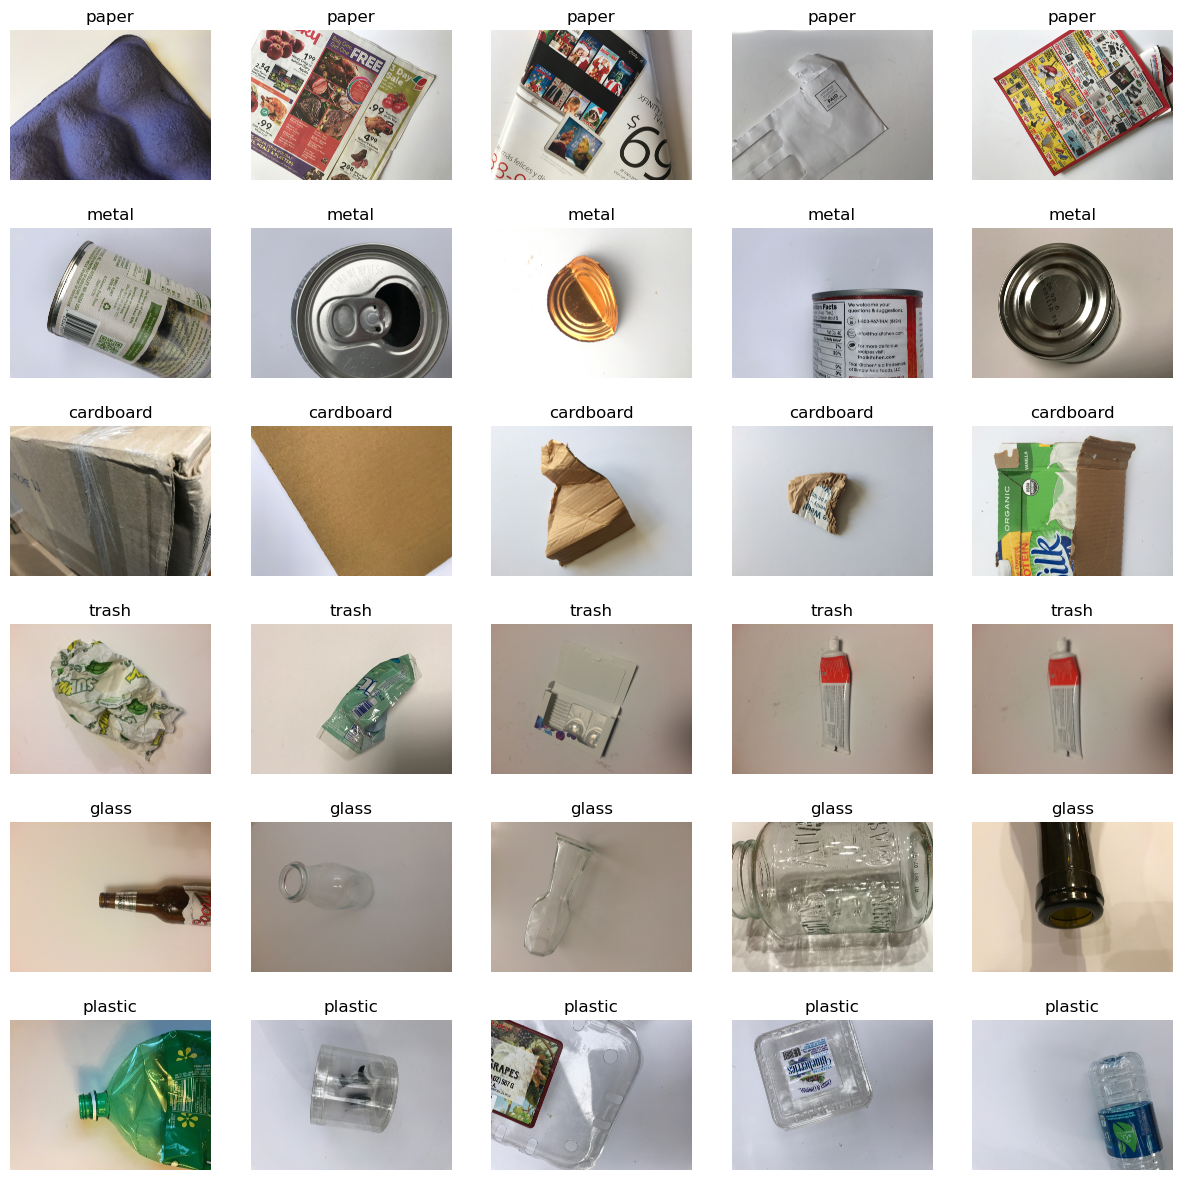

In [7]:
fig, ax = plt.subplots(figsize = (15, 15), nrows = len(folders), ncols=5)

for i, garbage_type in enumerate(folders):
    files = [file for file in os.listdir(RAW_DATA_PATH + garbage_type) if not file.startswith('.')]
    for j, file in enumerate(files[:5]):
        file_path = RAW_DATA_PATH + garbage_type + '/' + file
        plot_image(image = plt.imread(file_path), 
                   ax = ax[i, j], 
                   label = garbage_type)

plt.show()

## Loading the Dataset

The number of loaded images matches the total identified earlier: 2,527.

The dataset is divided into two main parts: 70% for the training dataset and 30% for the validation dataset. The validation dataset is further split into two subsets: 10% for validation and 20% for testing.

Before loading, the images are shuffled to ensure randomness, resized to 180x180 pixels, and cropped.

In [8]:
IMAGE_WIDTH = IMAGE_HEIGHT = 180
BATCH_SIZE = 32

train_ds, valid_ds = image_dataset_from_directory(
    RAW_DATA_PATH,                      # Path to the folder with images allocated in six folders according to garbage type
    labels = 'inferred',
    label_mode = 'int',
    class_names = folders,              # Labels correlates with folders names
    color_mode = 'rgb',
    batch_size = BATCH_SIZE,
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT),   # The targes image size
    shuffle = True,                     # Shuffle during load
    seed = 1812,
    validation_split = 0.3,             # Optional float between 0 and 1, fraction of data to reserve for validation and test sets
    subset = 'both',                    # One of "training", "validation", or "both". Only used if validation_split is set.
    interpolation = 'bilinear',
    follow_links = False,
    crop_to_aspect_ratio = True,        # Save the images proportions by cropping to aspect ratio
    pad_to_aspect_ratio = False,
    data_format = None,
    verbose = True
    )

Found 2527 files belonging to 6 classes.
Using 1769 files for training.
Using 758 files for validation.


In [9]:
valid_number_of_batches = tf.data.experimental.cardinality(valid_ds)
test_ds = valid_ds.take((2 * valid_number_of_batches) // 3)
valid_ds = valid_ds.skip((2 * valid_number_of_batches) // 3)

To verify that the images have been loaded correctly, we will display a sample of 9 images. These images will provide a visual confirmation of the dataset’s integrity and preprocessing steps.

2025-01-22 00:30:06.526137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


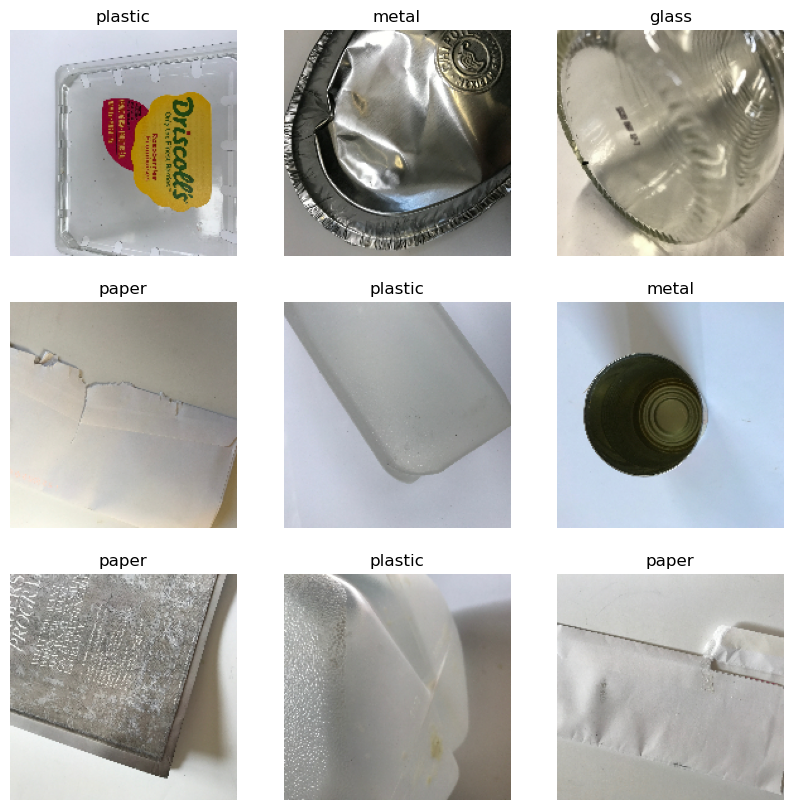

In [10]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))

# Take elements of batch_size from a tensor
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plot_image(image = images[i].numpy().astype("uint8"), 
                   ax = plt.subplot(3, 3, i + 1), 
                   label = class_names[labels[i]])

To ensure that all images are loaded correctly and correspond to their respective garbage types, we will count the number of images for each class label. The results confirm that the number of images per class matches the previously identified totals.

In [11]:
class_counts = defaultdict(int)

# Iterate through the datasets
for _, labels in train_ds.concatenate(valid_ds).concatenate(test_ds):
    for label in labels.numpy():
        class_counts[int(label)] += 1

# Print class counts
print(f"{'Class':<12}{'Count':>10}")
print("-" * 25)
for class_label, count in class_counts.items():
    print(f"{class_names[class_label]:<14} {count} images")

Class            Count
-------------------------
glass          501 images
metal          410 images
cardboard      403 images
paper          594 images
plastic        482 images
trash          137 images


2025-01-22 00:30:46.617818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Augmentation of the Dataset

The dataset size is relatively small, so we will use data augmentation to increase the number of images available for training the model. Only the training images will be augmented, while the validation and testing datasets will remain unchanged.

We will apply augmentation on-the-fly, meaning augmented images will not be added to the original training dataset beforehand. Instead, we will define a pipeline that applies several random augmentations (such as rotation, translation, zoom, brightness, and contrast adjustment) dynamically. This pipeline generates modified images only when needed — during model training. This approach conserves memory and provides a “new” dataset for each epoch, enhancing model generalization.

In [12]:
# Define the augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.1),
    layers.RandomTranslation(height_factor = 0.2, 
                             width_factor = 0.2,
                             fill_mode = 'nearest'),
    layers.RandomZoom(0.3, fill_mode = 'nearest'),
    layers.RandomBrightness([-0.2,0.2]), 
    layers.RandomContrast(0.2),
    ])

# Define a function to apply augmentation
def augment_images(image, label):
    image = data_augmentation(image)                                # Apply augmentations
    return image, label

# Augment and prefetch the testing dataset
augmented_train_ds = (
    train_ds
    .map(augment_images, num_parallel_calls = tf.data.AUTOTUNE)     # Apply augmentations
    .prefetch(tf.data.AUTOTUNE)                                     # Prefetch for performance
    )

# Create the validation dataset without augmentation
valid_ds = (
    valid_ds
    .prefetch(tf.data.AUTOTUNE)
)

To verify the results of the augmentation process, we will display the original image alongside 11 randomly augmented versions of it.

2025-01-22 00:30:47.950367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


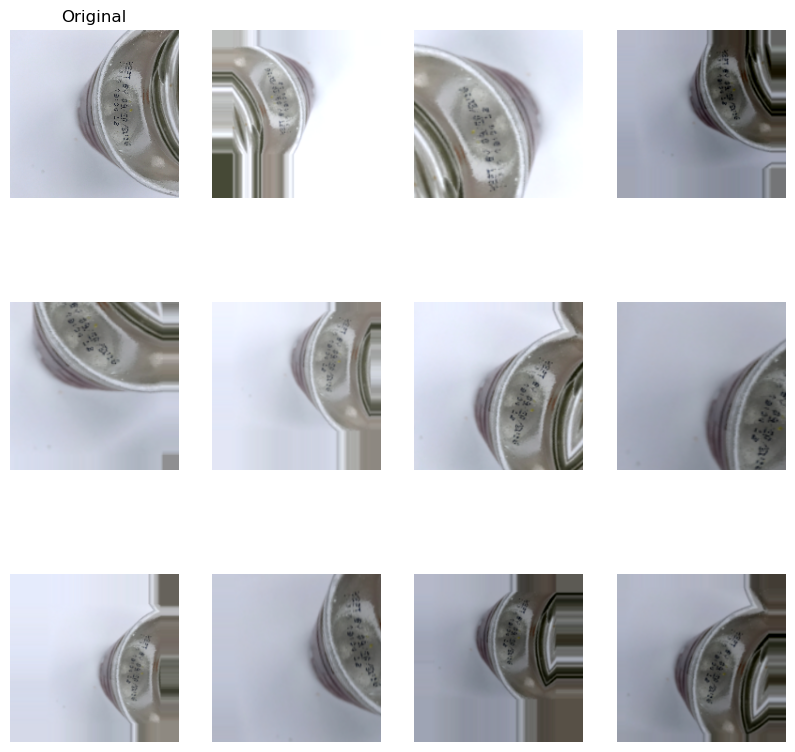

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    plot_image(image = np.array(images[1]).astype("uint8"), 
               ax = plt.subplot(3, 4, 1), 
               label = 'Original')
    for i in range(11):
        augm_im, _ = augment_images(images, labels)
        plot_image(image = np.array(augm_im[1]).astype('uint8'), ax = plt.subplot(3, 4, i + 2))

### Final Verification

To ensure the pipeline is correctly configured and generates the appropriate tensors for model training, we will implement a simple training run. This test will verify the accuracy and functionality of all the algorithms described above.

In [14]:
# Build a simple model
model = models.Sequential([
    layers.Input(shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(128, (11, 11), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (5, 5), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.25),
    layers.Dense(6, activation="softmax")
])

In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 170, 170, 128)  │        46,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 85, 85, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 81, 81, 64)     │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 17, 17, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9248)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       591,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 871,494 (3.32 MB)

 Trainable params: 871,494 (3.32 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Compile the model
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [17]:
# model = models.load_model('my_model_v4.keras')

In [18]:
# Train the model with augmented data
model.fit(augmented_train_ds, epochs = 10, validation_data = valid_ds)

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - accuracy: 0.3404 - loss: 1.5583 - val_accuracy: 0.3008 - val_loss: 1.6568
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.3462 - loss: 1.5634 - val_accuracy: 0.4024 - val_loss: 1.4822
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - accuracy: 0.3735 - loss: 1.5152 - val_accuracy: 0.4106 - val_loss: 1.4377
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - accuracy: 0.3558 - loss: 1.5105 - val_accuracy: 0.3171 - val_loss: 1.6186
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.2739 - loss: 1.6371 - val_accuracy: 0.3415 - val_loss: 1.5829
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - accuracy: 0.3464 - loss: 1.5705 - val_accuracy: 0.4350 - val_loss: 1.4314
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - accuracy: 0.3974 - loss: 1.4582 - val_accuracy: 0.3740 - val_loss: 1.4737
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - accuracy: 0.3667 - loss: 1.5263 - val_accuracy: 0.3577 - v

In [19]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_ds)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4025 - loss: 1.4305
Test Loss: 1.4025509357452393
Test Accuracy: 0.439453125


In [20]:
model.save('my_model_v4.keras')

## Conclusions  
1.	Data Loading and Verification  
    -	The dataset was successfully loaded, containing 2,527 images classified into six garbage types. All files were verified to be intact, with no missing or corrupted data.  
2.	Preprocessing Pipeline  
    -	Images were resized to 180x180 pixels to reduce computational overhead while preserving essential visual features for classification.  
    -	Data was split into training, validation, and testing sets to ensure a robust evaluation of the model’s performance.  
3.	Data Augmentation  
    -	To address the limited dataset size, an on-the-fly data augmentation pipeline was implemented. This approach ensures memory efficiency and dynamically generates a variety of augmented images during model training, enhancing the model’s ability to generalize.  
4.	Pipeline Validation  
    -	A simple model training was conducted to confirm the correctness of the entire pipeline, including data loading, preprocessing, and augmentation. This test verified the pipeline’s readiness for full-scale model training.  
5.	Key Learnings and Next Steps  
    -	The data processing and augmentation pipelines are critical for ensuring the model’s success in handling limited datasets. The implemented methods will serve as a solid foundation for the upcoming model development and training phases.  
    -	Future work will focus on fine-tuning the model architecture, optimizing hyperparameters, and evaluating the model’s performance on real-world test cases.  